In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scipy.stats as stats

#### Generating synthetic data

In [3]:
class MHP:
    def __init__(self, alpha=[[0.5]], mu=[0.1], omega=1.0):
        '''
        params should be of form
        alpha: numpy.array((u,u)), mu: numpy.array((,u)), omega: float
        '''
        
        self.data = []
        self.alpha, self.mu, self.omega = np.array(alpha), np.array(mu), omega
        self.dim = self.mu.shape[0]
        self.check_stability()

    def check_stability(self):
        '''
        check stability of process (max alpha eigenvalue < 1)
        '''
        w,v = np.linalg.eig(self.alpha)
        me = np.amax(np.abs(w))
        print('Max eigenvalue: %1.5f' % me)
        if me >= 1.:
            print('(WARNING) Unstable.')

In [4]:
class MHP(MHP): # for Jupyter notebook cells to link
    
    def generate_seq(self, horizon):
        '''
        Generate a sequence based on mu, alpha, omega values. 
        Uses Ogata's thinning method, with some speedups, noted below
        '''

        self.data = []  # clear history

        Istar = np.sum(self.mu)
        s = np.random.exponential(scale=1./Istar)

        # attribute (weighted random sample, since sum(mu)==Istar)
        n0 = np.random.choice(np.arange(self.dim), 
                              1, 
                              p=(self.mu / Istar))
        self.data.append([s, n0])

        # value of \lambda(t_k) where k is most recent event
        # starts with just the base rate
        lastrates = self.mu.copy()

        decIstar = False
        while True:
            tj, uj = self.data[-1][0], int(self.data[-1][1])

            if decIstar:
                # if last event was rejected, decrease Istar
                Istar = np.sum(rates)
                decIstar = False
            else:
                # otherwise, we just had an event, so recalc Istar (inclusive of last event)
                Istar = np.sum(lastrates) + \
                        self.omega * np.sum(self.alpha[:,uj])

            # generate new event
            s += np.random.exponential(scale=1./Istar)

            # calc rates at time s (use trick to take advantage of rates at last event)
            rates = self.mu + np.exp(-self.omega * (s - tj)) * \
                    (self.alpha[:,uj].flatten() * self.omega + lastrates - self.mu)

            # attribution/rejection test
            # handle attribution and thinning in one step as weighted random sample
            diff = Istar - np.sum(rates)
            try:
                n0 = np.random.choice(np.arange(self.dim+1), 1, 
                                      p=(np.append(rates, diff) / Istar))
            except ValueError:
                # by construction this should not happen
                print('Probabilities do not sum to one.')
                self.data = np.array(self.data)
                return self.data

            if n0 < self.dim:
                self.data.append([s, n0])
                # update lastrates
                lastrates = rates.copy()
            else:
                decIstar = True

            # if past horizon, done
            if s >= horizon:
                self.data = np.array(self.data)
                self.data = self.data[self.data[:,0] < horizon]
                return self.data

#### Creating $A$ (infectivity) vectors with varying variance

In [7]:
# Creating vectors with varying variance

variances = np.array([0.25*n for n in range(1, 13)]) # ranging from 0 to 3, with step size 0.25
sigmas = np.sqrt(variances) # standard deviations

mu = 0
lower, upper = 0, np.inf
A_vectors = [] # initializations for A 
A_vectors_Ogata = [] # square A for Ogata
for sigma in sigmas:
    dist = stats.truncnorm((lower - mu)/sigma, (upper - mu)/sigma, loc=mu, scale=sigma)
    A_vectors.append(dist.rvs(10))
    A_vectors_Ogata.append(dist.rvs(100).reshape((10, 10)))

A_vectors.insert(0, np.zeros(10)) # adding vector with 0 variance
A_vectors_Ogata.insert(0, np.zeros((10,10)))

#print(A_vectors_Ogata)

#print(A_vectors)
print(variances)
print(len(variances))

for A_vector in A_vectors:
    print(A_vector)
    print("")

[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.  ]
12
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[0.84736637 0.27931777 0.52688793 0.4503575  0.1382976  0.60348146
 0.20841798 0.64875955 0.10886136 0.10346769]

[0.52125421 0.20173566 0.68169301 0.24135218 0.6736526  1.3787922
 0.3383593  0.1961858  0.2136822  0.27759572]

[0.87962125 1.72850296 0.57070151 0.23485886 0.46731428 0.88563518
 1.24706029 0.22386745 1.70258614 0.32790435]

[0.82616726 0.8227874  1.07001728 1.47831506 0.72349572 1.28954622
 0.92387113 1.61599061 0.98673608 0.51470472]

[1.95467984 0.41540732 0.23078918 0.9720462  1.16774295 1.07795292
 0.25767871 1.45574041 0.11202289 2.15455366]

[2.40639905 1.66382502 0.7529488  2.2930217  1.52273008 1.76124735
 0.25365615 0.77928094 0.44059947 0.45131596]

[1.51170446 4.87839618 2.007925   0.21225867 0.00681352 0.66842813
 0.71852962 0.3147465  2.66912668 0.23500475]

[0.78882902 1.20777149 0.52239125 1.7043274  0.8420983  2.9785418
 1.22482588 2.09396719 1.69444586 0.880

#### Getting simulation sequence (simulation_seq)

In [15]:
num_event_types = 10 # number of units
mu = np.random.rand(1, 10).reshape((10,)) # random initialization

A = A_vectors_Ogata[2]

P = MHP(mu=mu, alpha=A) # using default omega value
P.generate_seq(100)

Max eigenvalue: 6.07554
(WARNING) Unstable.


KeyboardInterrupt: 

In [ ]:
mu = np.random.rand(5,)
A = np.random.rand(5,5)

P = MHP(mu=mu, alpha=A)
simulation_seq = P.generate_seq(50)
print(simulation_seq)

#### Simulation plots (variance in A and μ)

Text(0.5, 1.0, 'Simulation: Learning Infectivity')

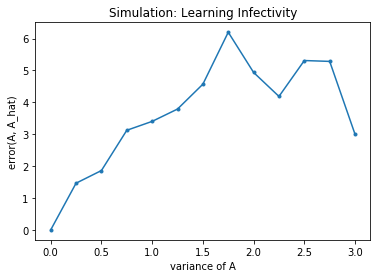

In [22]:
# Plotting 'variances' (in A) by 'errors' (Euclidean distances)

variances = [0.25*n for n in range(1, 13)]
variances.insert(0, 0)
#errors = [0,1.46118146075164,1.85792203224989,3.11963031062086,3.39843125294209,3.7852465842657,4.56479124345319,6.19380830421468,4.93248279383736,4.18150430471774,5.30638934180977,5.27926301556557,2.9924684815692]
errors = [0,1.46491518936275,1.86147236132768,3.12332331930089,3.40263719434106,3.78887014976776,4.56857227457589,6.19677964543199,4.93643449914371,4.18517206822057,5.3100168185097,5.28259438101623,2.99615739319619]

plt.plot(variances, errors, marker='.')
plt.xlabel("variance of A")
plt.ylabel("error(A, A_hat)")
plt.title("Simulation: Learning Infectivity")


In [18]:
# Learning mu

variances = np.array([0.25*n for n in range(1, 13)]) # ranging from 0 to 3, with step size 0.25
sigmas = np.sqrt(variances) # standard deviations

mu = 0
lower, upper = 0, np.inf
mu_vectors = [] # initializations for A 
for sigma in sigmas:
    dist = stats.truncnorm((lower - mu)/sigma, (upper - mu)/sigma, loc=mu, scale=sigma)
    mu_vectors.append(dist.rvs(1))
mu_vectors.insert(0, np.zeros(1))

print(mu_vectors)
print(len(mu_vectors))

[array([0.]), array([0.1590235]), array([0.12238107]), array([0.39250569]), array([0.36222051]), array([0.24485692]), array([0.26842871]), array([0.12801003]), array([0.8855262]), array([0.07668322]), array([0.39326933]), array([0.12125819]), array([0.31266145])]
13


Text(0.5, 1.0, 'Simulation: Learning Base Rates')

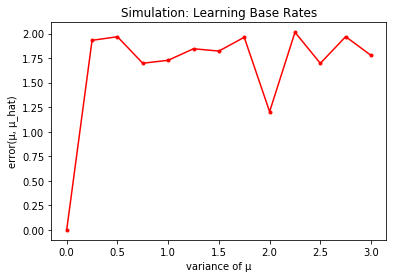

In [24]:
# Plotting 'variances' (in mu) by 'errors' (Euclidean distances)

variances = [0.25*n for n in range(1, 13)]
variances.insert(0, 0)
#mu_errors = [0,0.441071023700129,0.477713188699904,0.207589854054933,0.237874935516751,0.355238068343921,0.331666382362215,0.472084273381284,0.285429546162864,0.523410591933487,0.206826216461765,0.478836059581192,0.287433819344601]
mu_errors = [0,1.930925645808,1.96756798502503,1.69744378917771,1.72772893800153,1.84509238061535,1.82152062455986,1.96193904046581,1.20442361742767,2.01326567749704,1.69668014993668,1.96869086186701,1.77728794175166]


plt.plot(variances, mu_errors, marker='.', color='r')
plt.xlabel("variance of μ")
plt.ylabel("error(μ, μ_hat)")
plt.title("Simulation: Learning Base Rates")

#### Simulation plots (number of events/timestamps)